# PAC/PVC/NORMAL BEAT CLASSIFICATION

## Part 2: feature selection and model selection (ML, DL, hybrid). 

In this notebook, we import the features extracted in 'Notebook1' and we will perform scaling. Then, we will select relevant features only and feed them to different classifiers, to identify the best one. 
Moreover, we will introduce a deep learning approach and an hybrid approach, combining the deep learning model with the temporal features. 

## Import libraries

In [1]:
from scipy.io import loadmat
import numpy as np, os, sys, joblib
import re
from os.path import dirname, join as pjoin
import matplotlib.pyplot as plt
import pandas as pd

# Machine learning

## Load features

In [2]:
dataset = pd.read_csv('') # Insert path to the csv file containing all the features exctracted in 'Notebook1'
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212674 entries, 0 to 212673
Data columns (total 71 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               212674 non-null  int64  
 1   RR_prima         212674 non-null  float64
 2   RR_dopo          212674 non-null  float64
 3   dRR_prima        212674 non-null  float64
 4   dRR_dopo         212674 non-null  float64
 5   mean_RR_3        212674 non-null  float64
 6   std_RR_3         212674 non-null  float64
 7   std_dRR_3        212674 non-null  float64
 8   pNN_50_3         212674 non-null  float64
 9   RMSSD_3          212674 non-null  float64
 10  pNN_10_3         212674 non-null  float64
 11  pNN_20_3         212674 non-null  float64
 12  pNN_30_3         212674 non-null  float64
 13  pNN_40_3         212674 non-null  float64
 14  mean_RR_15       212674 non-null  float64
 15  std_RR_15        212674 non-null  float64
 16  std_dRR_15       212674 non-null  floa

## Feature analysis

### Check for NaNs

In [3]:
dataset.isna().sum()

ID                 0
RR_prima           0
RR_dopo            0
dRR_prima          0
dRR_dopo           0
                  ..
max_corr_pr_80     0
lag_pr_80          0
max_corr_pr2_80    0
lag_pr2_80         0
label              0
Length: 71, dtype: int64

### Plot distributions

array([[<AxesSubplot:title={'center':'ID'}>,
        <AxesSubplot:title={'center':'RR_prima'}>,
        <AxesSubplot:title={'center':'RR_dopo'}>,
        <AxesSubplot:title={'center':'dRR_prima'}>,
        <AxesSubplot:title={'center':'dRR_dopo'}>,
        <AxesSubplot:title={'center':'mean_RR_3'}>,
        <AxesSubplot:title={'center':'std_RR_3'}>,
        <AxesSubplot:title={'center':'std_dRR_3'}>],
       [<AxesSubplot:title={'center':'pNN_50_3'}>,
        <AxesSubplot:title={'center':'RMSSD_3'}>,
        <AxesSubplot:title={'center':'pNN_10_3'}>,
        <AxesSubplot:title={'center':'pNN_20_3'}>,
        <AxesSubplot:title={'center':'pNN_30_3'}>,
        <AxesSubplot:title={'center':'pNN_40_3'}>,
        <AxesSubplot:title={'center':'mean_RR_15'}>,
        <AxesSubplot:title={'center':'std_RR_15'}>],
       [<AxesSubplot:title={'center':'std_dRR_15'}>,
        <AxesSubplot:title={'center':'pNN_50_15'}>,
        <AxesSubplot:title={'center':'RMSSD_15'}>,
        <AxesSubplot:title={

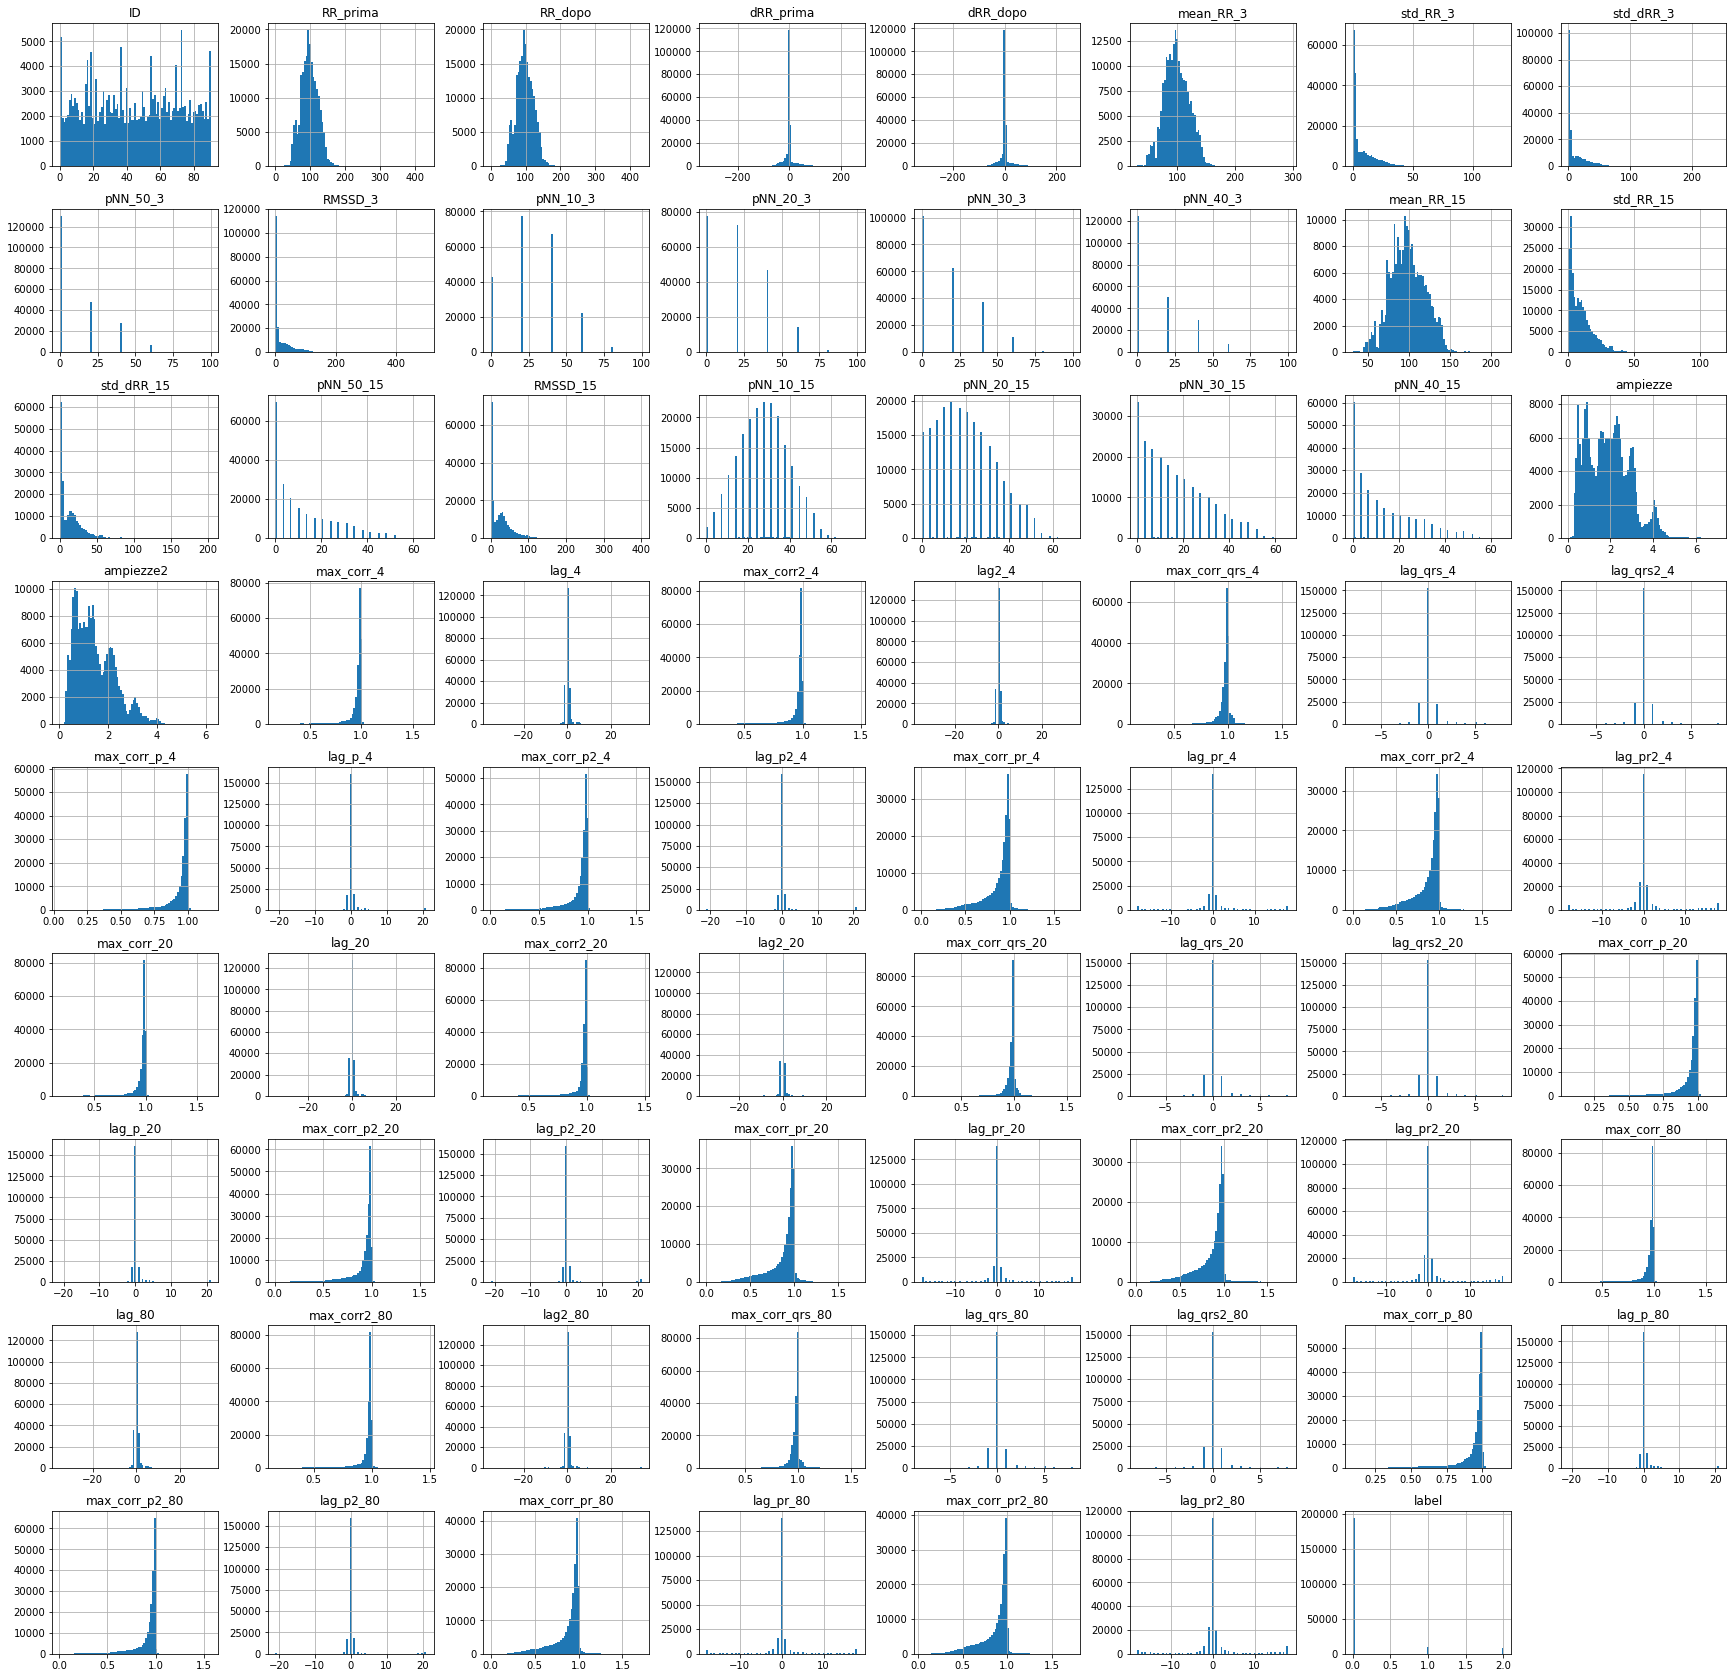

In [4]:
dataset.hist(xlabelsize=10,ylabelsize=10,figsize=(30,30), bins=85)

<AxesSubplot:>

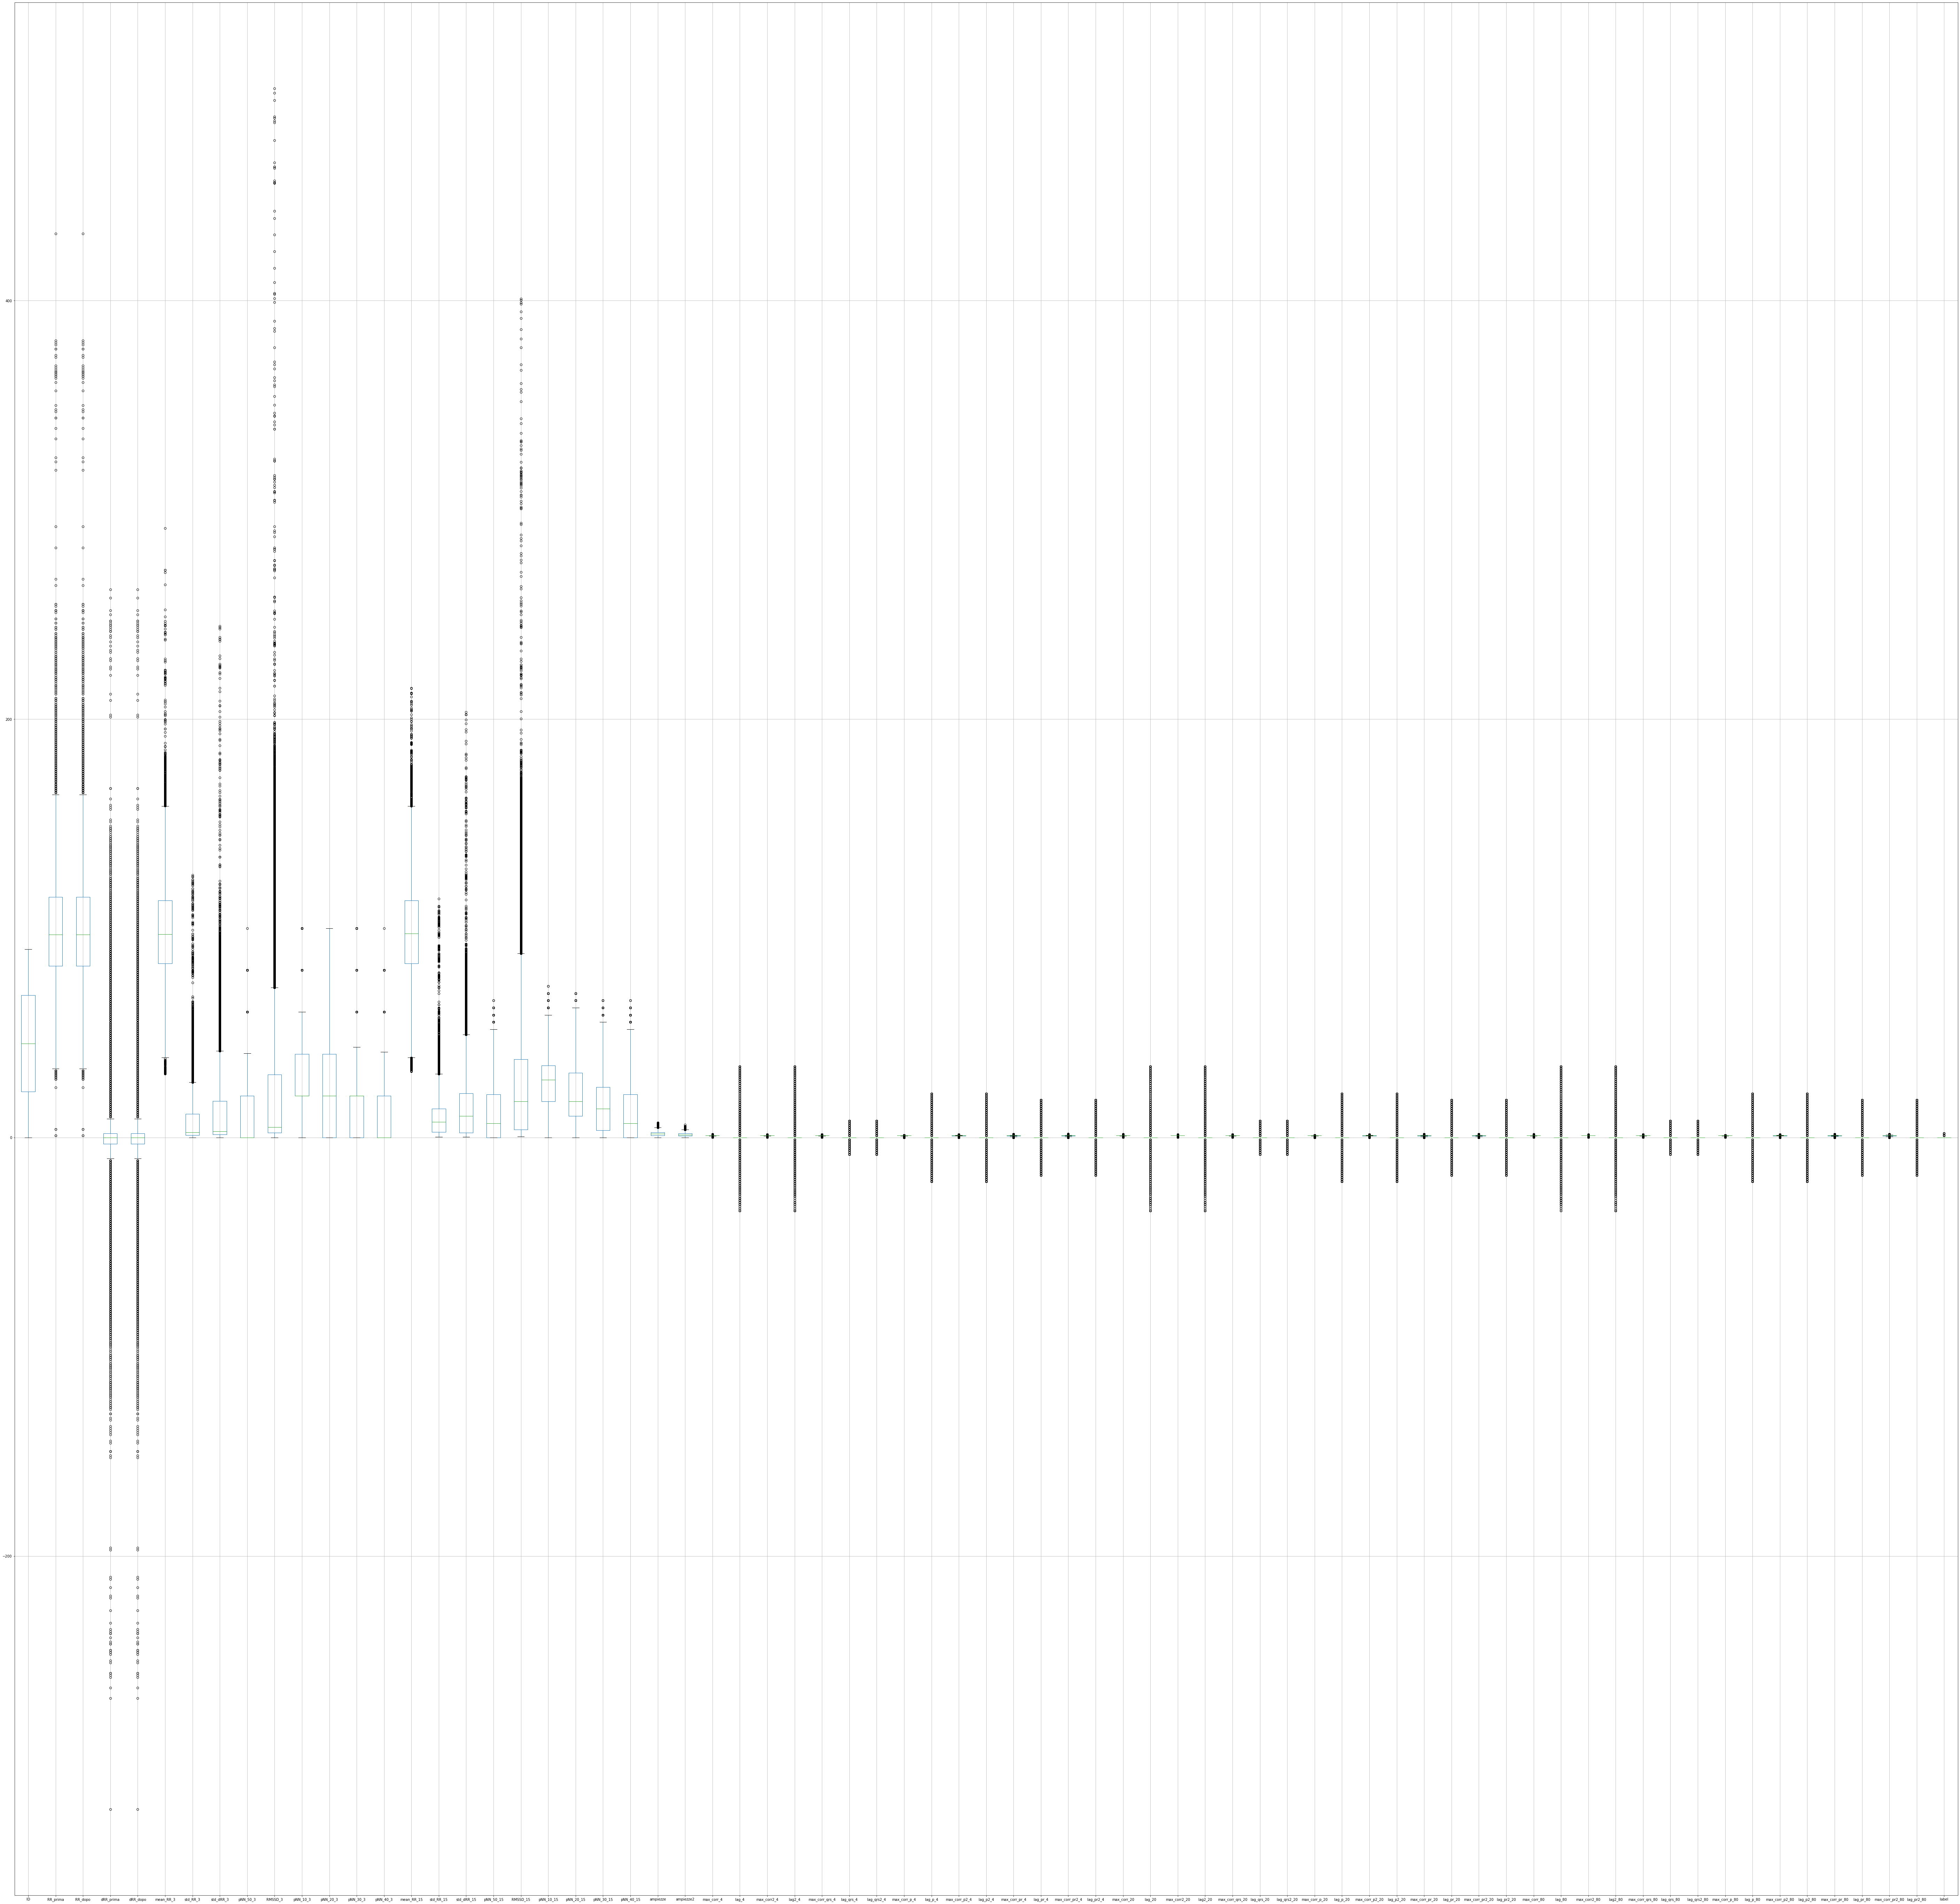

In [5]:
dataset.boxplot(figsize=(100,100))

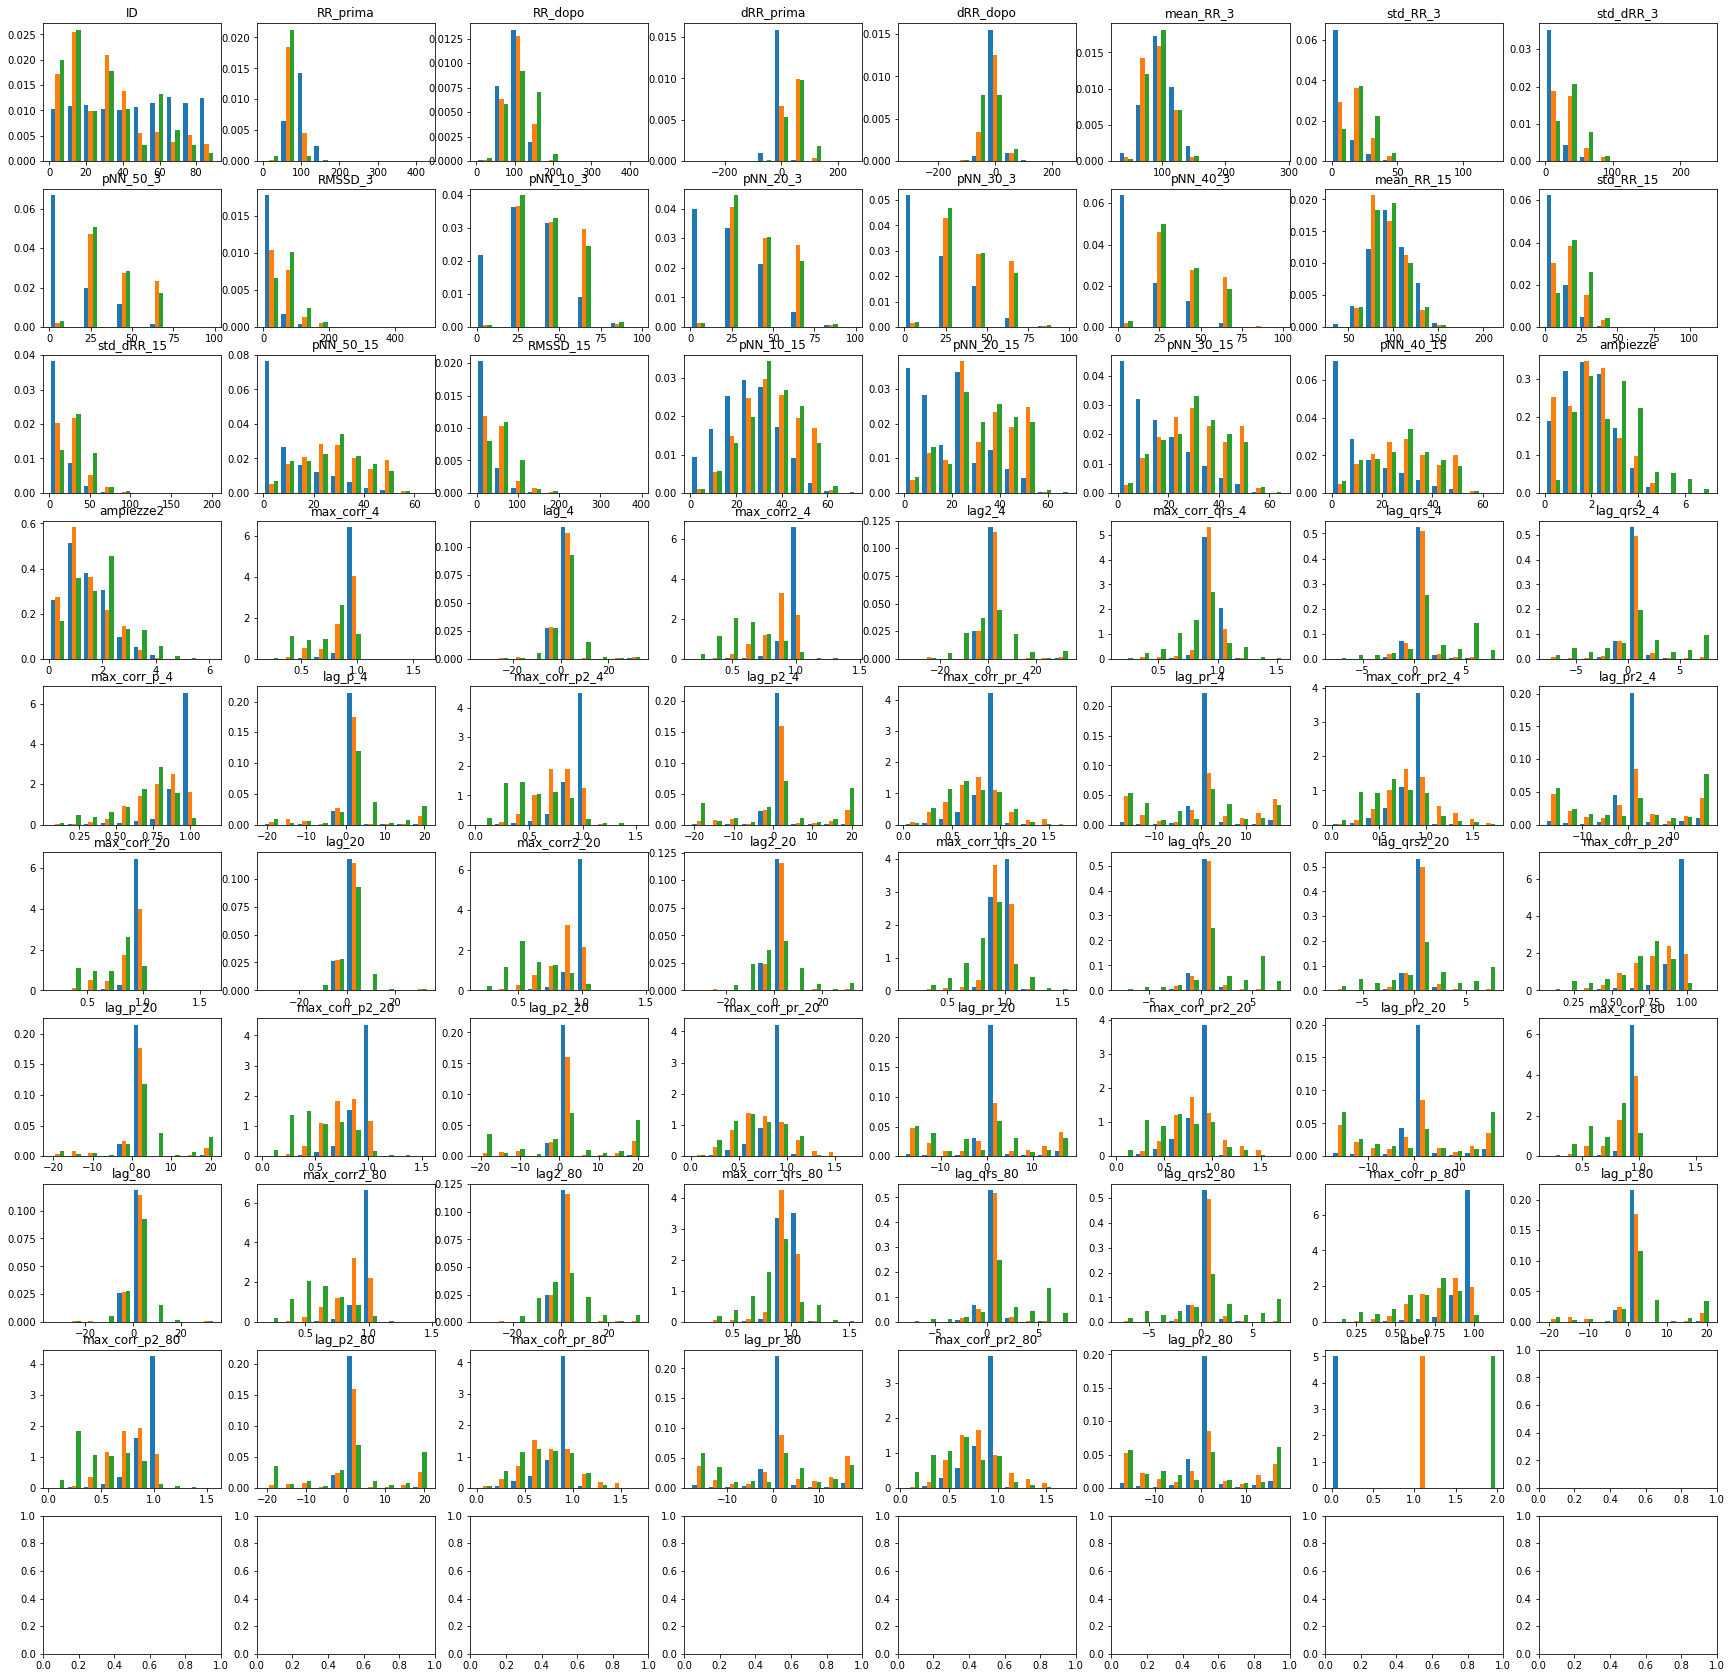

In [6]:
t0=dataset[dataset['label']==0]
t1=dataset[dataset['label']==1]
t2=dataset[dataset['label']==2]

fig,axes =plt.subplots(9,8,figsize=[30,30])
axes = axes.flatten()

i=0
for x in dataset.columns:

    plt.sca(axes[i]) 

    plt.hist([t0[x],t1[x],t2[x]],density=True)

    plt.title(x)

    i+=1

plt.show()

### Dimensionality reduction

#### Low variance features

In [7]:
feature_list = dataset.columns
feature_list=feature_list.drop(["ID","label"])
feature_list

Index(['RR_prima', 'RR_dopo', 'dRR_prima', 'dRR_dopo', 'mean_RR_3', 'std_RR_3',
       'std_dRR_3', 'pNN_50_3', 'RMSSD_3', 'pNN_10_3', 'pNN_20_3', 'pNN_30_3',
       'pNN_40_3', 'mean_RR_15', 'std_RR_15', 'std_dRR_15', 'pNN_50_15',
       'RMSSD_15', 'pNN_10_15', 'pNN_20_15', 'pNN_30_15', 'pNN_40_15',
       'ampiezze', 'ampiezze2', 'max_corr_4', 'lag_4', 'max_corr2_4', 'lag2_4',
       'max_corr_qrs_4', 'lag_qrs_4', 'lag_qrs2_4', 'max_corr_p_4', 'lag_p_4',
       'max_corr_p2_4', 'lag_p2_4', 'max_corr_pr_4', 'lag_pr_4',
       'max_corr_pr2_4', 'lag_pr2_4', 'max_corr_20', 'lag_20', 'max_corr2_20',
       'lag2_20', 'max_corr_qrs_20', 'lag_qrs_20', 'lag_qrs2_20',
       'max_corr_p_20', 'lag_p_20', 'max_corr_p2_20', 'lag_p2_20',
       'max_corr_pr_20', 'lag_pr_20', 'max_corr_pr2_20', 'lag_pr2_20',
       'max_corr_80', 'lag_80', 'max_corr2_80', 'lag2_80', 'max_corr_qrs_80',
       'lag_qrs_80', 'lag_qrs2_80', 'max_corr_p_80', 'lag_p_80',
       'max_corr_p2_80', 'lag_p2_80', 'max_corr

In [8]:
from sklearn.feature_selection import VarianceThreshold 
from itertools import compress

# identify low variance features, choosing a threshold of 0.03

vt = VarianceThreshold(threshold=(0.03))
features_var = vt.fit_transform(dataset)
mask = vt.get_support() 

features_notconst = dataset.loc[:, mask]

# plot deleted features
print('Deleted features: ' + str(list(compress(feature_list, ~mask))))

Deleted features: ['lag_4', 'lag2_4', 'lag_qrs_4', 'lag_p_4', 'lag_p2_4', 'lag_pr_4', 'lag_pr2_4', 'lag_20', 'lag2_20', 'lag_qrs_20', 'lag_p_20', 'lag_p2_20', 'lag_pr_20', 'lag_pr2_20', 'lag_80', 'lag2_80', 'lag_qrs_80', 'lag_p_80', 'lag_p2_80', 'lag_pr_80']


In [9]:
# delete those features with variance < 0.03
dataset = dataset.drop(list(compress(feature_list, ~mask)), axis=1)
dataset.head()

,ID,RR_prima,RR_dopo,dRR_prima,dRR_dopo,mean_RR_3,std_RR_3,std_dRR_3,pNN_50_3,RMSSD_3,...,max_corr_80,max_corr2_80,max_corr_qrs_80,lag_qrs2_80,max_corr_p_80,max_corr_p2_80,max_corr_pr_80,max_corr_pr2_80,lag_pr2_80,label
0,0,80.810175,81.0,-0.001404,0.0,80.813240,1.730018,2.680506,1.195079,4.696443,...,0.922540,0.969152,0.914163,0,1.004112,0.967402,0.997667,0.984855,1,0
1,0,81.000000,81.0,0.000000,0.0,80.813240,1.730018,2.680506,1.195079,4.696443,...,0.923362,0.960370,0.961283,0,0.982943,0.959067,0.962370,0.941143,0,0
2,0,81.000000,81.0,0.000000,0.0,80.813240,1.730018,2.680506,1.195079,4.696443,...,0.932188,0.943654,0.957618,0,0.976604,0.957379,0.947710,0.937245,0,0
3,0,81.000000,81.0,0.000000,-1.0,80.833333,0.372678,0.632456,0.000000,1.118034,...,0.928641,0.909033,0.970436,1,0.941270,0.939394,0.926730,0.898204,0,0
4,0,81.000000,80.0,-1.000000,1.0,80.833333,0.372678,0.632456,0.000000,1.224745,...,0.925596,0.987516,1.009872,1,0.933164,0.998102,0.929046,0.890420,0,0


In [10]:
feature_list = dataset.columns
feature_list=feature_list.drop(["ID","label"])
feature_list

Index(['RR_prima', 'RR_dopo', 'dRR_prima', 'dRR_dopo', 'mean_RR_3', 'std_RR_3',
       'std_dRR_3', 'pNN_50_3', 'RMSSD_3', 'pNN_10_3', 'pNN_20_3', 'pNN_30_3',
       'pNN_40_3', 'mean_RR_15', 'std_RR_15', 'std_dRR_15', 'pNN_50_15',
       'RMSSD_15', 'pNN_10_15', 'pNN_20_15', 'pNN_30_15', 'pNN_40_15',
       'ampiezze', 'ampiezze2', 'max_corr_4', 'max_corr2_4', 'max_corr_qrs_4',
       'lag_qrs2_4', 'max_corr_p_4', 'max_corr_p2_4', 'max_corr_pr_4',
       'max_corr_pr2_4', 'max_corr_20', 'max_corr2_20', 'max_corr_qrs_20',
       'lag_qrs2_20', 'max_corr_p_20', 'max_corr_p2_20', 'max_corr_pr_20',
       'max_corr_pr2_20', 'max_corr_80', 'max_corr2_80', 'max_corr_qrs_80',
       'lag_qrs2_80', 'max_corr_p_80', 'max_corr_p2_80', 'max_corr_pr_80',
       'max_corr_pr2_80', 'lag_pr2_80'],
      dtype='object')

#### Correlated features

In [11]:
def plot_correlationMatrix(correlation_matrix, features):
    f = plt.figure(figsize=(20, 20))
    plt.matshow(correlation_matrix, fignum=f.number)
    plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
    plt.yticks(range(len(features)), features, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #plt.title('Correlation Matrix', fontsize=16)
    # plt.tight_layout()
    return 

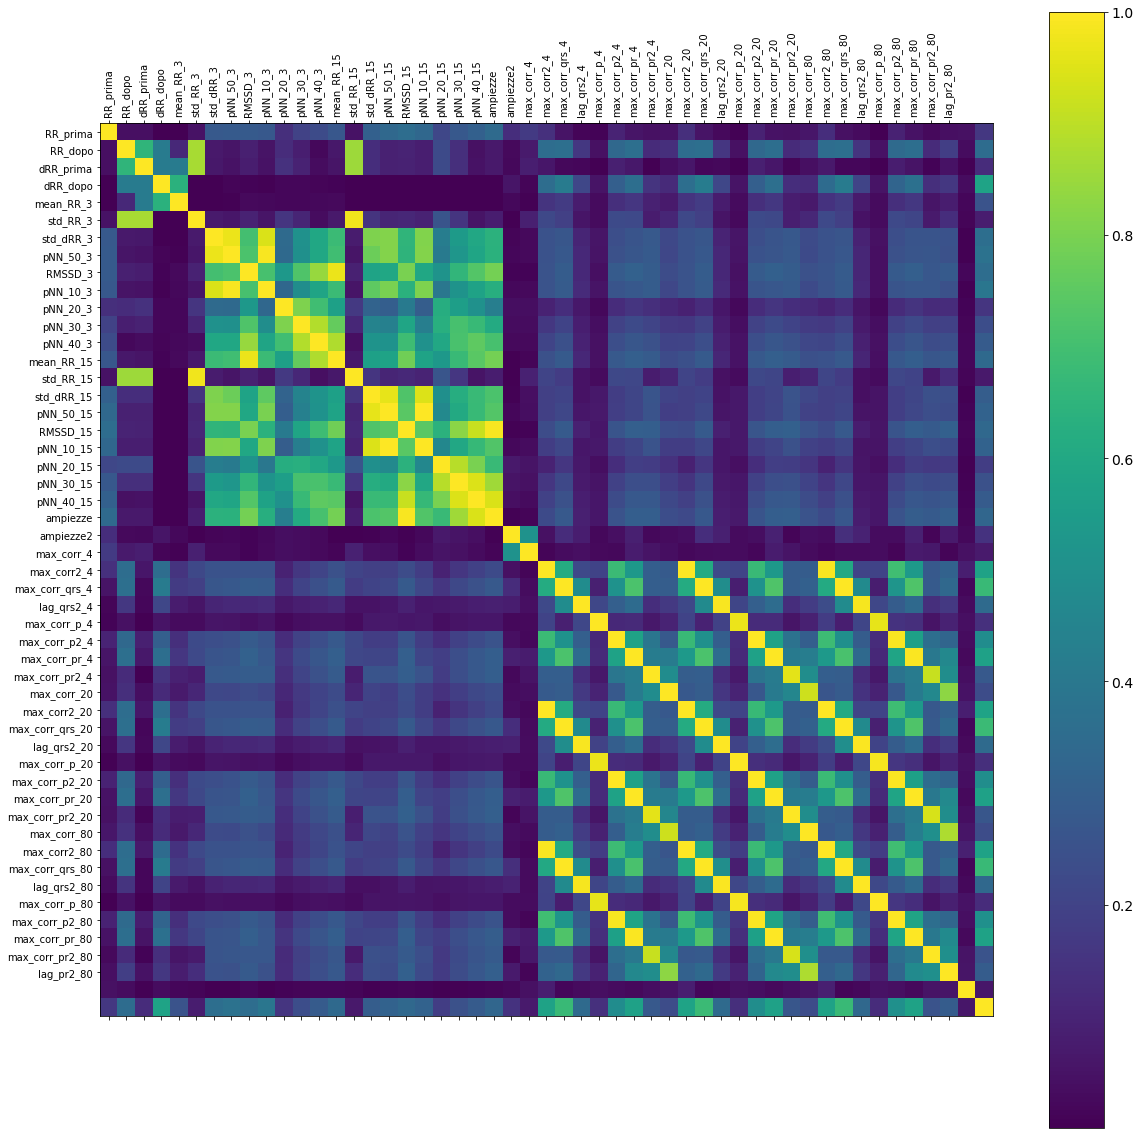

In [12]:
# visualize correlation matrix
cor_matrix = dataset.corr().abs()
plot_correlationMatrix(cor_matrix, feature_list)

# Identify correleted features, choosing a threshold of 0.95
correlated_features = set()
correlation_matrix = dataset.corr()
mean_corr = (correlation_matrix.abs()).mean(axis=0)

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            if mean_corr[i] > mean_corr[j]:
                colname = correlation_matrix.columns[i]
                
            else:
                colname = correlation_matrix.columns[j]
                
            correlated_features.add(colname)

Deleted features: {'max_corr_p2_80', 'max_corr_qrs_20', 'std_dRR_15', 'mean_RR_3', 'max_corr_4', 'max_corr_pr_4', 'pNN_50_15', 'max_corr_20', 'max_corr2_20', 'max_corr_p_80', 'max_corr_qrs_4', 'max_corr_p2_4', 'lag_qrs2_4', 'lag_qrs2_20', 'std_dRR_3', 'max_corr2_4', 'max_corr_p_4', 'pNN_50_3'}


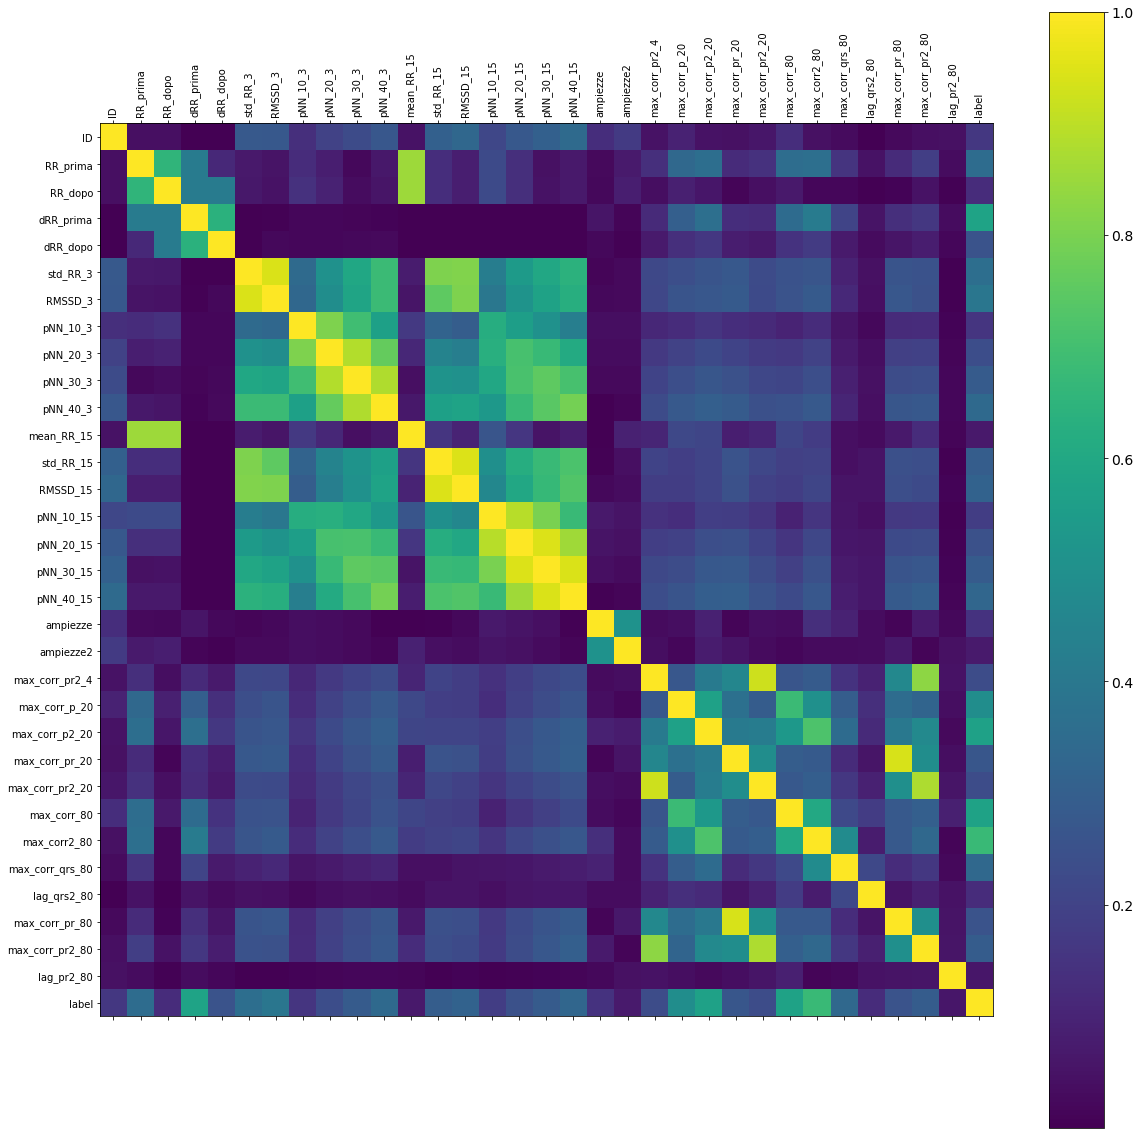

In [13]:
# Drop correlated features

dataset = dataset.drop(labels=correlated_features, axis=1)                     
print('Deleted features: ' + str(correlated_features))

# plot correlation matrix with remaining features
cor_matrix = dataset.corr().abs()
feature_list = list(dataset.columns)
f2 = plot_correlationMatrix(cor_matrix, feature_list)

## K-fold TRAIN-TEST split

In [16]:
groups = dataset.ID
x = dataset
y = dataset.label

In [18]:
from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=13)

result = []   

distrs = [get_distribution(y)]
index = ['dataset']
i=0
for train_idx, val_idx in group_kfold.split(x, y, groups):
    i=i+1
    train_fold = x.iloc[train_idx]
    val_fold = x.iloc[val_idx]
    result.append((train_fold, val_fold))
    
    distrs.append(get_distribution(train_fold.label))
    index.append(f'training set - fold {i}')
    distrs.append(get_distribution(val_fold.label))
    index.append(f'test set - fold {i}')


train_fold_1, val_fold_1 = result[0][0],result[0][1]
train_fold_2, val_fold_2 = result[1][0],result[1][1]
train_fold_3, val_fold_3 = result[2][0],result[2][1]
train_fold_4, val_fold_4 = result[3][0],result[3][1]
train_fold_5, val_fold_5 = result[4][0],result[4][1]
train_fold_6, val_fold_6 = result[5][0],result[5][1]
train_fold_7, val_fold_7 = result[6][0],result[6][1]
train_fold_8, val_fold_8 = result[7][0],result[7][1]
train_fold_9, val_fold_9 = result[8][0],result[8][1]
train_fold_10, val_fold_10 = result[9][0],result[9][1]
train_fold_11, val_fold_11= result[10][0],result[10][1]
train_fold_12, val_fold_12 = result[11][0],result[11][1]
train_fold_13, val_fold_13 = result[12][0],result[12][1]

In [20]:
# Check class distribution for each fold
from collections import Counter, defaultdict
def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]
    
display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(y) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2
dataset,91.82%,4.52%,3.67%
training set - fold 1,91.48%,4.62%,3.90%
test set - fold 1,95.69%,3.39%,0.92%
training set - fold 2,91.36%,4.83%,3.80%
test set - fold 2,97.13%,0.82%,2.04%
training set - fold 3,91.54%,4.71%,3.75%
test set - fold 3,95.12%,2.24%,2.64%
training set - fold 4,92.04%,4.73%,3.23%
test set - fold 4,89.10%,2.00%,8.91%
training set - fold 5,91.87%,4.46%,3.67%


In [21]:
# Concatenate training and test folds
# val_fold: test set folds
# train_fold: train set folds

train_fold=[ train_fold_1, train_fold_2, train_fold_3, train_fold_4, train_fold_5, train_fold_6, train_fold_7, train_fold_8, train_fold_9, train_fold_10, train_fold_11, train_fold_12, train_fold_13  ]
val_fold= [val_fold_1, val_fold_2, val_fold_3, val_fold_4, val_fold_5, val_fold_6, val_fold_7, val_fold_8, val_fold_9, val_fold_10, val_fold_11, val_fold_12, val_fold_13]

## Training 

In [23]:
# Function to perform hyperparameter search with GridSearchCV, train the model and return the best model based on f1_macro score
# it performs also the predictions using the best model and return them.

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import f1_score

def hyperp_search(classifier, parameters,cv, X_train, y_train, X_test):

    gs = GridSearchCV(classifier, parameters, cv=cv, scoring = 'f1_macro', verbose=5, n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test) 
    
    return best_model, y_pred

In [24]:
# This is a function to create folds that follows the idea: 
# have a stratification for target and have separated groups inside the folds
# This is used to create the validation folds for cv inside the training phase

from collections import Counter, defaultdict
from sklearn.utils import check_random_state
import random

def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [25]:
# This function includes several sections:
# 1) take 12 folds for training and 1 fold for testing 
# 2) perform scaling with StandardScaler
# 3) inside each training fold, split into 10 train and validation sets, mantaining stratification among the classes and paying 
# attention to keep beats from the same patient into the same set (using stratified_group_k_fold function)
# 4) Apply hyperp_search to train the model and make predictions.

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample

def multi_function(train_fold, val_fold, model, parameters, fold_number): 

# 1) Train-test folds selection

    X_train_fold=train_fold[fold_number] # train fold 
    X_train= X_train_fold.drop(['label','ID'], axis=1)
    y_train= X_train_fold.label.astype(int)
    groups= X_train_fold.ID

    X_val_fold=val_fold[fold_number] # test fold 
    X_test= X_val_fold.drop(['label','ID'], axis=1)
    y_test=X_val_fold.label.astype(int)

# 2) Scaling
    transformer = StandardScaler().fit(X_train)

    train_features_zscore = transformer.transform(X_train) # into dataframe
    feature_list = X_train.columns
    X_train_features = pd.DataFrame(data=train_features_zscore, columns=feature_list)

    # Adapt test set
    test_features_zscore = transformer.transform(X_test)
    X_test_features = pd.DataFrame(data=test_features_zscore, columns=feature_list)
    
    y_train_resample = y_train
    pazienti = groups
    X_train_resample = X_train_features
    
# 3) Train-validation split
    cv = stratified_group_k_fold(X_train_resample, y_train_resample, pazienti, k=10, seed=None)

# 4) Train the model and obtain predictions
    classifier = model     
    best_model, y_pred = hyperp_search(classifier, parameters,cv, X_train_resample, y_train_resample, X_test_features)
       
    return y_test, y_pred, best_model 

## Model evaluation 

In [26]:
from sklearn.ensemble import ExtraTreesClassifier

model= ExtraTreesClassifier()
parameters={
    'n_estimators': [100],
    'criterion': ['entropy'],
'max_depth': [20],
'min_samples_split': [15],
'min_samples_leaf': [7],
            'class_weight':['balanced']
           } # These are the optimal parameters resulting from the grid search process 

In [25]:
# Make prediction for each test fold
labels=[]
predictions=[]

for i in range(len(train_fold)):
    
    label, prediction, best_model= multi_function(train_fold, val_fold, model, parameters, i)
    labels.append(label)
    predictions.append(prediction)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
f1_train: 0.760575 using {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 100}
Fitting 10 folds for each of 1 candidates, totalling 10 fits
f1_train: 0.765584 using {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 100}
Fitting 10 folds for each of 1 candidates, totalling 10 fits
f1_train: 0.752606 using {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 100}
Fitting 10 folds for each of 1 candidates, totalling 10 fits
f1_train: 0.743797 using {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 100}
Fitting 10 folds for each of 1 candidates, totalling 10 fits
f1_train: 0.745553 using {'class_weight

In [26]:
# Concatenate the predictions
target=np.concatenate(labels, axis=0)
pred = np.concatenate(predictions, axis=0)

array([0, 0, 0, ..., 0, 0, 0])

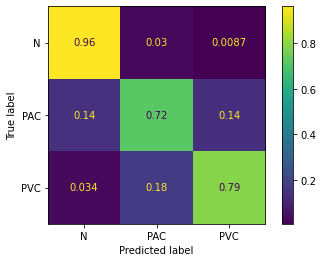

[[187656   5919   1695]
 [  1376   6880   1353]
 [   262   1382   6151]]
              precision    recall  f1-score   support

           N       0.99      0.96      0.98    195270
         PAC       0.49      0.72      0.58      9609
         PVC       0.67      0.79      0.72      7795

    accuracy                           0.94    212674
   macro avg       0.72      0.82      0.76    212674
weighted avg       0.96      0.94      0.95    212674



In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_confusionMatrix(test_labels, test_predicted):
    cm = confusion_matrix(test_labels, test_predicted)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=cmn,
                                display_labels=['N', 'PAC','PVC'])
    disp.plot()
    plt.show()
    
    print(confusion_matrix(test_labels, test_predicted))
    print(classification_report(test_labels, test_predicted, target_names=['N', 'PAC','PVC']))
    return 

plot_confusionMatrix(target, pred)

# Deep learning

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

## Import data

In [ ]:
fs=128
T=1/fs

features = pd.read_csv('') # Insert path to the csv file containing all the features exctracted in 'Notebook1'
L1=np.load('') # Import beats' windows extracted in 'Notebook1' of lead 1
L2=np.load('') # Import beats' windows extracted in 'Notebook1' of lead 2

## Build dataframe

In [ ]:
battiti1 = pd.DataFrame(L1) # lead 1
battiti2 = pd.DataFrame(L2) # lead 2

In [ ]:
battiti1['label']=features.label
battiti1['ID']=features.ID

battiti1.head() 

In [ ]:
battiti2['label']=features.label
battiti2['ID']=features.ID

battiti2.head()  

## Inspect dataframe

In [ ]:
battiti1['label']=battiti1['label'].astype(int)
battiti1['label'].value_counts()

In [ ]:
c=battiti1.groupby('label',group_keys=False).apply(lambda battiti1 : battiti1.sample(1))
c

In [ ]:
f, axes = plt.subplots(2, 2, sharex=False, sharey=False) 
f.set_figheight(10)
f.set_figwidth(15)
axes[0,0].plot(c.iloc[0,:511])
axes[0,1].plot(c.iloc[1,:511])
axes[1,0].plot(c.iloc[2,:511])
axes[0,0].title.set_text('N')
axes[0,1].title.set_text('S')
axes[1,0].title.set_text('V')

## K-fold TRAIN-TEST split

Using the same procedure described above in the 'Machine learning' section

In [ ]:
groups = np.array(battiti1.ID)
y = np.array(battiti1.label)

# Create a dataframe containing both leads
battiti = pd.DataFrame({'L1':[i for i in L1],
                       'L2':[i for i in L2]})

battiti['label']=y
battiti['ID']=groups

battiti.head()

In [ ]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=13)

result = []   
for train_idx, val_idx in group_kfold.split(battiti, y, groups):
    train_fold = battiti.iloc[train_idx]
    val_fold = battiti.iloc[val_idx]
    result.append((train_fold, val_fold))
    
train_fold_1, val_fold_1 = result[0][0],result[0][1]
train_fold_2, val_fold_2 = result[1][0],result[1][1]
train_fold_3, val_fold_3 = result[2][0],result[2][1]
train_fold_4, val_fold_4 = result[3][0],result[3][1]
train_fold_5, val_fold_5 = result[4][0],result[4][1]
train_fold_6, val_fold_6 = result[5][0],result[5][1]
train_fold_7, val_fold_7 = result[6][0],result[6][1]
train_fold_8, val_fold_8 = result[7][0],result[7][1]
train_fold_9, val_fold_9 = result[8][0],result[8][1]
train_fold_10, val_fold_10 = result[9][0],result[9][1]
train_fold_11, val_fold_11= result[10][0],result[10][1]
train_fold_12, val_fold_12 = result[11][0],result[11][1]
train_fold_13, val_fold_13 = result[12][0],result[12][1]

In [ ]:
train_fold=[ train_fold_1, train_fold_2, train_fold_3, train_fold_4, train_fold_5, train_fold_6, train_fold_7, train_fold_8, train_fold_9, train_fold_10, train_fold_11, train_fold_12, train_fold_13  ]
val_fold= [val_fold_1, val_fold_2, val_fold_3, val_fold_4, val_fold_5, val_fold_6, val_fold_7, val_fold_8, val_fold_9, val_fold_10, val_fold_11, val_fold_12, val_fold_13]

## Training

In [ ]:
from keras.utils.np_utils import to_categorical 
from sklearn.utils import resample
from sklearn.utils import shuffle

# This function includes several sections:
# 1) take 12 folds for training and 1 fold for testing 
# 2) undersampling to deal with class imbalance
# 3) inside each training fold, split into train and validation sets, paying attention to keep beats from the same patient 
# into the same set using GroupKFold
# 4) fix shapes for inputs in the network
# 5) train the network and make prediction

def multi_function(train_fold, val_fold, fold_number):

# 1) Train-test folds selection

    X_train_fold=train_fold[fold_number] 
    X_train= X_train_fold.drop(['label','ID'], axis=1)
    y_train= X_train_fold.label.astype(int)

    X_val_fold=val_fold[fold_number]  
    X_test= X_val_fold.drop(['label','ID'], axis=1)
    y_test=X_val_fold.label.astype(int)

# 2) Resampling for class imbalance

    df_bal = X_train
    df_bal['label']=y_train.astype(int)
    df_bal['ID']=X_train_fold['ID']

    c = df_bal['label'].value_counts()
    samples = c.min()
    
    df_majority0= df_bal[df_bal['label']==0]
    df_majority_downsampled0 = resample(df_majority0,
    replace=False,
    n_samples=samples, # to match minority class
    random_state=42)

    df_majority1= df_bal[df_bal['label']==1]
    df_majority_downsampled1 = resample(df_majority1,
    replace=False, 
    n_samples=samples, # to match minority class
    random_state=42)

    df_majority2= df_bal[df_bal['label']==2] # this is the minority class
    
    df_downsampled = pd.concat([df_majority_downsampled0, df_majority_downsampled1, df_majority2])
    df = df_downsampled.reset_index(drop=True)
    df = shuffle(df)
    
    y_train_resample = df.label.astype(int)
    pazienti = df.ID.astype(int)
    
# 3) Train-validation split

    group_kfold = GroupKFold(n_splits = 10)

    result = []   
    for train_idx, val_idx in group_kfold.split(df, y_train_resample, pazienti):
        train_fold_2 = df.iloc[train_idx]
        val_fold_2 = df.iloc[val_idx]
        result.append((train_fold_2, val_fold_2))
    
    train, val = result[0][0],result[0][1] 
    
    y_train = train.label.astype(int)
    x_train_resample = train.drop(['label','ID'], axis=1)
    
    y_validation = val.label.astype(int)
    x_validation = val.drop(['label','ID'], axis=1)   
    
# 4) Fix shapes for the network
    
    y_train = to_categorical(y_train) # one-hot encoding of the labels
    y_test = to_categorical(y_test)
    y_validation=to_categorical(y_validation)
    
    x_train1 = np.stack(np.array(x_train_resample.L1))
    x_train2 = np.stack(np.array(x_train_resample.L2))
    x_train = np.dstack((x_train1,x_train2))
    
    x_test1 = np.stack(np.array(X_test.L1))
    x_test2 = np.stack(np.array(X_test.L2))
    x_test = np.dstack((x_test1,x_test2))
    
    x_val1 = np.stack(np.array(x_validation.L1))
    x_val2 = np.stack(np.array(x_validation.L2))
    x_validation = np.dstack((x_val1,x_val2))
      
# 5) Training and prediction

    model,history = network(x_train,y_train, x_validation, y_validation)
    model.evaluate((x_test),y_test, verbose=0)[1]
   
    pred = model.predict(x_test)
    predicted_class = np.argmax(pred, axis=-1)
    test = np.argmax(y_test, axis=-1)
    
    return model, history, test, predicted_class

### Model

In [ ]:
def attention_3d_block(inputs):
    input_dim = int(inputs.shape[2])
    a = inputs
    a = tfkl.Dense(input_dim, activation='softmax')(a)

    a_probs = tfkl.Permute((1, 2), name='attention_vec')(a)

    output_attention_mul = tfkl.Multiply()([inputs, a_probs])
    
    return output_attention_mul

In [ ]:
from keras.layers import Input
from keras.models import Model
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers

def network(X_train,y_train, x_validation, y_validation):
    
    im_shape=(X_train.shape[1],2)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    
    x = tfkl.Conv1D(filters = 128, kernel_size = 1, activation = 'relu')(inputs_cnn) 
    x = tfkl.Dropout(0.3)(x)
    
    lstm_out = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(x)
    lstm_out = tfkl.Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = tfkl.Flatten()(attention_mul)

    dense = tfkl.Dense(32, activation='relu')(attention_mul)
    
    main_output = Dense(3, activation='softmax', name='main_output')(dense)
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.summary()
    tfk.utils.plot_model(model)
    
    model.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy',metrics=tf.keras.metrics.CategoricalAccuracy())
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs = 25,callbacks=callbacks, batch_size = 128, validation_data=(x_validation,y_validation))
    model.load_weights('best_model.h5')
    
    return(model,history)

In [ ]:
# Train and make predictions for each test fold
labels=[]
predictions=[]

for i in range(len(train_fold)):
    
    model, history, test, predicted_class= multi_function(train_fold, val_fold, i)
    labels.append(test)
    predictions.append(predicted_class)

In [ ]:
target = np.concatenate(labels, axis=0)
pred = np.concatenate(predictions, axis=0)

## Model evaluation

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_confusionMatrix(test, predicted_class):
    cm = confusion_matrix(test, predicted_class)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=cmn,
                                display_labels=['N', 'PAC','PVC'])
    disp.plot()
    plt.show()
    
    print(confusion_matrix(test, predicted_class))
    print(classification_report(test, predicted_class, target_names=['N', 'PAC','PVC']))
    return

plot_confusionMatrix(target, pred)

# Hybrid: deep learning + temporal features from machine learning

## Import data

In [ ]:
fs=128
T=1/fs

features = pd.read_csv('') # Insert path to the csv file containing all the features exctracted in 'Notebook1'
L1=np.load('') # Import beats' windows extracted in 'Notebook1' of lead 1
L2=np.load('') # Import beats' windows extracted in 'Notebook1' of lead 2

## Create and inspect beats dataframe

In [ ]:
battiti1 = pd.DataFrame(L1)
battiti2 = pd.DataFrame(L2)

In [ ]:
battiti1['label']=features.label
battiti1['ID']=features.ID

battiti1.head()

In [ ]:
battiti2['label']=features.label
battiti2['ID']=features.ID

battiti2.head()

In [ ]:
battiti1['label']=battiti1['label'].astype(int)
battiti1['label'].value_counts()

In [ ]:
c=battiti1.groupby('label',group_keys=False).apply(lambda battiti1 : battiti1.sample(1))
c

In [ ]:
f, axes = plt.subplots(2, 2, sharex=False, sharey=False) 
f.set_figheight(10)
f.set_figwidth(15)

axes[0,0].plot(c.iloc[0,:511])
axes[0,1].plot(c.iloc[1,:511])
axes[1,0].plot(c.iloc[2,:511])

axes[0,0].set_xlabel('samples')
axes[0,1].set_xlabel('samples')
axes[1,0].set_xlabel('samples')
axes[0,0].set_ylabel('amplitude [mV]')
axes[0,1].set_ylabel('amplitude [mV]')
axes[1,0].set_ylabel('amplitude [mV]')

axes[0,0].title.set_text('N')
axes[0,1].title.set_text('S')
axes[1,0].title.set_text('V')

## Add temporal features to dataframe

In [ ]:
groups = np.array(battiti1.ID)
y = np.array(battiti1.label)

In [ ]:
b = pd.DataFrame({'L1':[i for i in L1],
                       'L2':[i for i in L2]})

In [ ]:
b['label'] = y
b['ID'] = groups

In [ ]:
# We add temporal features from the machine learning section, keeping only the ones which remained after dimensionality reduction
f = features[['RR_prima', 'RR_dopo', 'dRR_prima', 'dRR_dopo',  'std_RR_3',
       'RMSSD_3', 'pNN_10_3', 'pNN_20_3', 'pNN_30_3',
       'pNN_40_3', 'mean_RR_15',  'pNN_50_15',
       'RMSSD_15', 'pNN_10_15', 'pNN_20_15', 'pNN_30_15', 'pNN_40_15']].copy()

battiti = pd.concat([b, f], axis=1) # 'battiti' contains both features and beats from Lead 1 and Lead 2.

In [ ]:
battiti.head()

## K-fold TRAIN-TEST split

using the same procedure we used in the previous 'Machine learning' and 'Deep learning' sections.

In [ ]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=13)

result = []   
for train_idx, val_idx in group_kfold.split(battiti, y, groups):
    train_fold = battiti.iloc[train_idx]
    val_fold = battiti.iloc[val_idx]
    result.append((train_fold, val_fold))
    
train_fold_1, val_fold_1 = result[0][0],result[0][1]
train_fold_2, val_fold_2 = result[1][0],result[1][1]
train_fold_3, val_fold_3 = result[2][0],result[2][1]
train_fold_4, val_fold_4 = result[3][0],result[3][1]
train_fold_5, val_fold_5 = result[4][0],result[4][1]
train_fold_6, val_fold_6 = result[5][0],result[5][1]
train_fold_7, val_fold_7 = result[6][0],result[6][1]
train_fold_8, val_fold_8 = result[7][0],result[7][1]
train_fold_9, val_fold_9 = result[8][0],result[8][1]
train_fold_10, val_fold_10 = result[9][0],result[9][1]
train_fold_11, val_fold_11= result[10][0],result[10][1]
train_fold_12, val_fold_12 = result[11][0],result[11][1]
train_fold_13, val_fold_13 = result[12][0],result[12][1]

In [ ]:
train_fold=[ train_fold_1, train_fold_2, train_fold_3, train_fold_4, train_fold_5, train_fold_6, train_fold_7, train_fold_8, train_fold_9, train_fold_10, train_fold_11, train_fold_12, train_fold_13  ]
val_fold= [val_fold_1, val_fold_2, val_fold_3, val_fold_4, val_fold_5, val_fold_6, val_fold_7, val_fold_8, val_fold_9, val_fold_10, val_fold_11, val_fold_12, val_fold_13]

In [ ]:
# 1) Split train-test set
def train_test(train_fold, val_fold, fold_number):
    
    X_train_fold=train_fold[fold_number]  
    X_train_fold = X_train_fold.reset_index(drop=True)
    X_train= X_train_fold.drop(['label','ID'], axis=1)
    y_train= X_train_fold.label.astype(int)
    groups = X_train_fold.ID

    X_val_fold=val_fold[fold_number] 
    X_val_fold = X_val_fold.reset_index(drop=True)
    X_test= X_val_fold.drop(['label','ID'], axis=1)
    y_test=X_val_fold.label.astype(int)
        
    return X_train, y_train, X_test, y_test, groups

## Scaling features

In [ ]:
# 2) Scaling temporal features

from sklearn.preprocessing import StandardScaler
def scaling_features(X_train, X_test): 
    
    X_train_s = X_train[['L1','L2']]
    X_test_s = X_test[['L1','L2']]
    
    train_features = X_train.drop([ "L1","L2"], axis = 1)
    test_features = X_test.drop([ "L1","L2"], axis = 1)
    feature_list = train_features.columns
    
    transformer = StandardScaler().fit(train_features)
    # scale train set
    train_features_zscore = transformer.transform(train_features) 
    X_train_f = pd.DataFrame(data=train_features_zscore, columns=feature_list)
    
    # adapt test set
    test_features_zscore = transformer.transform(test_features)
    X_test_f= pd.DataFrame(data=test_features_zscore, columns=feature_list)
    
    X_train = pd.concat([X_train_f, X_train_s], axis=1)
    X_test = pd.concat([X_test_f, X_test_s], axis=1)
    
    return X_train, X_test


## Resampling

In [ ]:
# 3) Resampling to deal with class imbalance
from sklearn.utils import shuffle
from sklearn.utils import resample

def resampling(X_train, y_train, groups):
    
    df_bal = X_train
    df_bal['label']=y_train.astype(int)
    df_bal['ID'] = groups 

    c = df_bal['label'].value_counts()
    samples = c.min()
    
    df_majority0= df_bal[df_bal['label']==0]
    df_majority_downsampled0 = resample(df_majority0,
    replace=False,
    n_samples=samples, # to match minority class
    random_state=42)

    df_majority1= df_bal[df_bal['label']==1]
    df_majority_downsampled1 = resample(df_majority1,
    replace=False,
    n_samples=samples, # to match minority class
    random_state=42)

    df_majority2= df_bal[df_bal['label'] == 2] # This is the minority class
    
    df_downsampled = pd.concat([df_majority_downsampled0, df_majority_downsampled1, df_majority2])   
    df = shuffle(df_downsampled)
    df = df.reset_index(drop=True) 

    y_train_resample = df.label.astype(int)
    pazienti = df.ID.astype(int)
    x_train_resample = df # it contains features, label, signal and ID
    
    return x_train_resample, y_train_resample, pazienti


## Split train-validation

In [ ]:
# 4) Split train-validation

# This function returns:
# y_train: train labels
# x_train_s: train leads
# x_train_f: train features
# y_validation: validation labels
# x_validation_s: validation leads
# x_validation_f: validation features

def train_val(x_train_resample, y_train_resample, pazienti):
# create a validation set to be used during training
    group_kfold = GroupKFold(n_splits=10)

    result = []   
    for train_idx, val_idx in group_kfold.split(x_train_resample, y_train_resample, pazienti):
        train_fold_2 = x_train_resample.iloc[train_idx]
        val_fold_2 = x_train_resample.iloc[val_idx]
        result.append((train_fold_2, val_fold_2))
    
    train, val = result[0][0],result[0][1] 
    train = train.reset_index(drop=True)
    val = val.reset_index(drop=True)
    
    # divide again into signal and features
    y_train = train.label.astype(int)
    x_train_s = train[['L1','L2']]
    x_train_f = train.drop(['label','ID','L1','L2'], axis=1)
    
    y_validation = val.label.astype(int)
    x_validation_s = val[['L1','L2']]
    x_validation_f = val.drop(['label','ID','L1','L2'], axis=1) 
    
    return x_train_s, x_train_f, y_train, x_validation_s, x_validation_f, y_validation

## Adjust shapes for the network

In [ ]:
# 5) Adjust shapes for the network 
def adapt_data(x_train_s, x_train_f, y_train, x_validation_s, x_validation_f, y_validation, X_test, y_test):    
    
    # One-Hot encoding per le labels
    y_train = to_categorical(y_train)  
    y_validation = to_categorical(y_validation)
    y_test = to_categorical(y_test)
    
    # Train
    x_train1 = np.stack(np.array(x_train_s.L1))
    x_train2 = np.stack(np.array(x_train_s.L2))
    x_train_s = np.dstack((x_train1,x_train2))
        
    # Validation
    x_val1 = np.stack(np.array(x_validation_s.L1))
    x_val2 = np.stack(np.array(x_validation_s.L2))
    x_validation_s = np.dstack((x_val1,x_val2))
       
    # Test    
    x_test1 = np.stack(np.array(X_test.L1))
    x_test2 = np.stack(np.array(X_test.L2))
    x_test_s = np.dstack((x_test1,x_test2)) 
    x_test_f = X_test.drop(['L1','L2'], axis=1)
       
    return x_train_s, x_train_f, y_train, x_validation_s, x_validation_f, y_validation, x_test_s, x_test_f, y_test   

## Model

In [ ]:
def attention_3d_block(inputs):

    input_dim = int(inputs.shape[2])
    a = inputs
    a = tfkl.Dense(input_dim, activation='softmax')(a)

    a_probs = tfkl.Permute((1, 2), name='attention_vec')(a)
    
    output_attention_mul = tfkl.Multiply()([inputs, a_probs])
    return output_attention_mul

In [ ]:
# Model integrating deep + wide 
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers

def deep_features(ch, win_len, num_wide_features, classes): 
    # Inputs:
    # ch: number of leads
    # win_len: length of the window of signals
    # num_wide_features: number of temporal features
    # classes: target classes
    
    # A. Features
    wide_input = Input(shape= num_wide_features , name = 'wide_features')   
    wide_branch = Dense(20, activation='relu')(wide_input)
    
    # B. ECG window input of shape (batch_size, win_len, ch)
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal') 
    
    x = tfkl.Conv1D(filters = 128, kernel_size = 1, activation = 'relu')(ecg_input)  #, padding = 'same'
    x = tfkl.Dropout(0.3)(x)

    lstm_out = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(x)
    lstm_out = tfkl.Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    signal_branch = tfkl.Flatten()(attention_mul)
    
    # Concatenate feature layer and signal layer
    shared_path = concatenate([signal_branch, wide_branch], name='concat_layer')  
    shared_path = Dense(10, activation='relu')(shared_path)  
    shared_path = Dense(classes, activation='softmax', name='sigmoid_classifier')(shared_path)
   
    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[ecg_input,  wide_input], outputs=shared_path)

    return model

## Training

In [ ]:
def training(x_train_f,x_train_s,y_train, x_validation_s, x_validation_f, y_validation):
    
    model = deep_features( ch=2, win_len=512,num_wide_features= (17), classes=3)
    
    model.summary()
    tfk.utils.plot_model(model)
    model.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy',metrics=tf.keras.metrics.CategoricalAccuracy())
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    
    history=model.fit(
        x = [x_train_s, x_train_f], y = y_train, 
        validation_data = ([x_validation_s,x_validation_f], y_validation),
        
    steps_per_epoch=(len(x_train_s)/16),
    batch_size = 16,
    epochs = 20,
    callbacks=callbacks)

    model.load_weights('best_model.h5')
    
    return(model,history)

## Testing

In [ ]:
def testing(x_train_f, x_train_s, y_train, x_validation_s, x_validation_f, y_validation, x_test_s, x_test_f, y_test):
    
    model,history = training(x_train_f, x_train_s, y_train, x_validation_s, x_validation_f, y_validation)
   
    pred = model.predict([x_test_s, x_test_f])
    
    predicted_class = np.argmax(pred, axis=-1)
    test = np.argmax(y_test, axis=-1)
  
    return model, history, test, predicted_class

In [ ]:
def hybrid_learning(train_fold, val_fold, fold_number):
    
    # divide train-test
    X_train, y_train, X_test, y_test, groups = train_test(train_fold, val_fold, fold_number)
    
    # scaling
    X_train, X_test = scaling_features(X_train, X_test)
    
    # resampling
    x_train_resample, y_train_resample, pazienti = resampling(X_train, y_train, groups)
    
    # train-validation
    x_train_s, x_train_f, y_train, x_validation_s, x_validation_f, y_validation = train_val(x_train_resample, y_train_resample, pazienti)
    
    # adapt data 
    x_train_s, x_train_f, y_train, x_validation_s, x_validation_f, y_validation, x_test_s, x_test_f, y_test = adapt_data(x_train_s, x_train_f, y_train, x_validation_s, x_validation_f, y_validation, X_test, y_test)
    
    # training and testing
    model, history, test, predicted_class = testing(x_train_f, x_train_s, y_train, x_validation_s, x_validation_f, y_validation, x_test_s, x_test_f, y_test)
    
    return model, history, test, predicted_class

In [ ]:
labels=[]
predictions=[]

for i in range(len(train_fold)):
    
    model, history, test, predicted_class= hybrid_learning(train_fold, val_fold, i)
    labels.append(test)
    predictions.append(predicted_class)
    

## Evaluation

In [ ]:
target=np.concatenate(labels, axis=0)
pred = np.concatenate(predictions, axis=0)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def plot_confusionMatrix(test_labels, test_predicted):
    cm = confusion_matrix(test_labels, test_predicted)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=cmn,
                                display_labels=['N', 'PAC','PVC'])
    disp.plot()
    plt.show()
    
    print(confusion_matrix(test_labels, test_predicted))
    print(classification_report(test_labels, test_predicted, target_names=['N', 'PAC','PVC']))
    return 

plot_confusionMatrix(target, pred)